In [5]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)


import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import grad
from scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt

from src.state_eqn import velocity

# Create Fake Radial Velocity Data

/var/folders/wd/zr_by8q96891mxc_506sm9sr0000gn/T/ipykernel_77975/2915516410.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "+k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(time_obs, rv_obs, yerr=rv_err, fmt="+k", label="Observed Data", color='black')


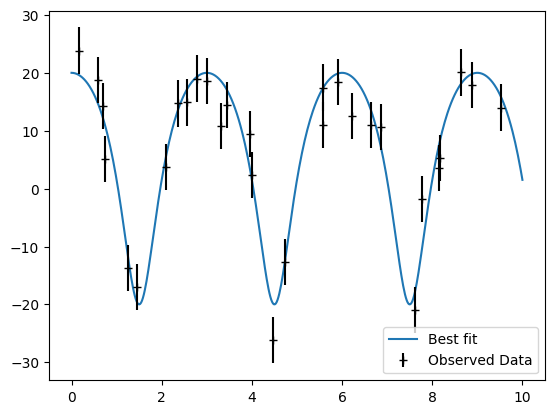

In [6]:
tf = 10
t = jnp.linspace(0, tf, 500)  # 500 time points over 10 days

# Orbital parameters
period = 3.0          # Orbital period in days
eccentricity = 0.3    # Moderate eccentricity
omega = jnp.pi / 1   # Argument of periastron in radians 
phi0 = 2*jnp.pi/2    # Phase offset (in radians)
K = 20.0              # Semi-amplitude of velocity in m/s
v0 = 0.0              # Systemic velocity offset in m/s

initial_params = jnp.array([period, eccentricity, omega, phi0, K, v0])

# True Data
rv_true = velocity(t, period, eccentricity, omega, phi0, K, v0)

# Observed Data
n_observed = 30
time_obs = np.sort(np.random.uniform(0, tf, n_observed))
rv_err = 4
rv_obs = velocity(time_obs, period, eccentricity, omega, phi0, K, v0) + rv_err * np.random.normal(size=len(time_obs))


plt.plot(t, rv_true, label="Best fit")
plt.errorbar(time_obs, rv_obs, yerr=rv_err, fmt="+k", label="Observed Data", color='black')
plt.legend(loc='lower right')
plt.show()


# Maximum Likelihood Inference, using `jax.scipy.optimize.minimize`

In [7]:
from src.likelihood import Likelihood

likelihood = Likelihood(times=time_obs, 
                        observed_data=rv_obs, 
                        uncertainity=rv_err, 
                        jitter=0.0)

In [8]:
neglikelihood = lambda params: -1 * likelihood(params)

neg_likelihood_grad = jax.jit(grad(neglikelihood))

# Starting point
# period, eccentricity, omega, phi0, K, v0
initial_params = jnp.array([period, eccentricity, omega, phi0, K, v0])

# Wrapper for SciPy which works with jax.np
def scipy_obj(params_np):
    params = jnp.array(params_np)
    val = float(neglikelihood(params))
    grad_val = jnp.array(neg_likelihood_grad(params))
    return val, grad_val

# Optimize
res = minimize(scipy_obj, 
               x0=initial_params, 
               jac=True, 
               bounds=((0.0, None), (0.0, None), (0.0, 360), (0.0, 360), (0.0, None), (0.0, None)))

# Best-fit parameters
best_params = res.x
print("Optimized parameters:", best_params)
print(f"Best likelihood: {likelihood(best_params)}")

Optimized parameters: [ 3.0074156   0.29718738  3.20149387  3.15774416 18.66989554  0.        ]
Best likelihood: -15.904695991075846


/var/folders/wd/zr_by8q96891mxc_506sm9sr0000gn/T/ipykernel_77975/4229787306.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "+k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(time_obs, rv_obs, yerr=rv_err, fmt="+k", label="Observed Data", color='black')


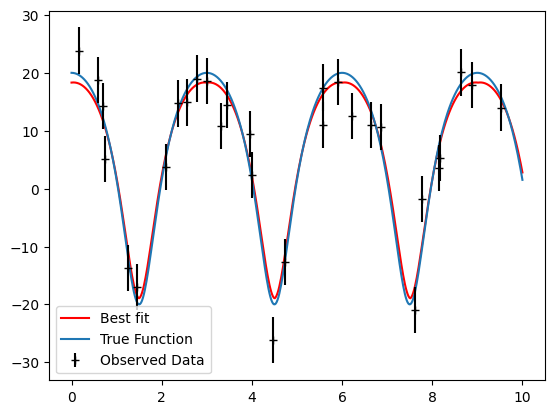

In [9]:
period_best, eccentricity_best, omega_best, phi0_best, K_best, v0_best  = best_params

# Visualization
plt.plot(t, velocity(t=t, period=period_best, eccentricity=eccentricity_best, omega=omega_best, phi0=phi0_best, K=K_best, v0=v0_best), label="Best fit", color='red')
plt.plot(t, rv_true, label="True Function")
plt.errorbar(time_obs, rv_obs, yerr=rv_err, fmt="+k", label="Observed Data", color='black')
plt.legend(loc='lower right')
plt.legend()
plt.show()


# Sampling

I'll create a corner plot of the posterior, using the priors in `/src/prior.py`